<!--NOTEBOOK_HEADER-->*This notebook contains material for CBE 20258 Numerical and Statistical Analysis taught at the University of Notre Dame. (c) Professors Alexander Dowling, Ryan McClarren, and Yamil Colón. This collection of notebooks [cbe-xx258](https://ndcbe.github.io/cbe-xx258) is available [on Github](https://github.com/ndcbe/cbe-xx258).*


<!--NAVIGATION-->
< [1.9 Functions as Arguments](https://ndcbe.github.io/cbe-xx258/01.09-Functions-as-Arguments.html) | [Contents](toc.html) | [2.0 Linear Algebra](https://ndcbe.github.io/cbe-xx258/02.00-Linear-Algebra.html) ><p><a href="https://colab.research.google.com/github/ndcbe/cbe-xx258/blob/master/docs/01.10-Testing-and-Debugging.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe-xx258/01.10-Testing-and-Debugging.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 1.10 Testing and Debugging in Python

**Reference**: Chapter 6 of *Computational Nuclear Engineering and Radiological Science Using Python*, R. McClarren (2018)

### 1.10.1 Learning Objectives

After studying this notebook, completing the activities, and asking questions in class, you should be able to:
* Create `assert` statements and `try`-`except` blocks of code
* Embrace the "debugging mindset" and test code you write it. We strongly recommend creating a handful of unit tests for each function you write, especially for complex codes (e.g., mini-projects)

## 1.10.1 Testing Your Code

Anytime you write code, you want to make sure that it accomplishes the desired task.

### Motivating Example

Through an example, we will demonstrate several strategies for systematically testing code.

Phenolphthalein is a base indicator (it turns a pretty purple), but in the presence of a strong base it will fade over time.  This is a reversible reaction: pseudo first order in the forward (fading) direction and first order in the reverse direction.  The rate expression is:

$$
\frac{d[P]}{dt} = -k_{1}[P][OH^-]+k_{2}[POH] ~,
$$
 
where $k_{1}' = k_{1}  \cdot [OH^-]$ is the pseudo first order rate. $[POH]$ is only produced from this reaction, thus we have the mass balance:

$$
[POH] = [POH]\Big|_{t=0}+([P]_{0}-[P]) ~.
$$

With the initial conditions:

$$
[P]\Big|_{t=0}=[P]_{0}\qquad; \qquad [POH]\Big|_{t=0}=0 ~.
$$

We can solve these equations to get the solution:

$$
[P] = [P]_{0}\Big(\frac{k_{2}}{k_{1}'+k_{2}}+\frac{k_{1}'}{k_{1}'+k_{2}}e^{-(k_{1}'+k_{2})t}\Big) ~.
$$

Let's examine a Python function to calculate the solution.

In [1]:
import numpy as np
def P_conc(t, P0, k1prime, k2, LOUD=False):
    """ Computes the concentration of phenolphthalein as a function of time
    
    Args:
        t: time, either a scalar (float) or vector (numpy array)
        P0: initial concentration of phenolphthalein
        k1prime: forward reaction rate constant
        k2: reverse reaction rate constant
        
    Returns:
        concentration, either a scalar (float) or vector (numpy array) depening in arg. t
    """
    # compute first fraction in formula
    frac1 = k2/(k1prime + k2)
    
    # compute section fraction in formula
    frac2 = k1prime/(k1prime + k2)
    
    # compute term that goes into exponent
    pre_expon = -(k1prime * k2)*t
    
    # evaluate exponent
    expon = np.exp(pre_expon)
    
    # combine together
    P = P0*(frac1 + frac2*expon)
    
    if LOUD:
        print("frac1 = ",frac1)
        print("frac2 = ",frac2)
        print("pre_expon = ",pre_expon)
        print("expon = ",expon)
        print("P = ",P)
    
    # return final value
    return P

We will now go through several tests to see if our function behaves correctly. *Note:* There are a few intentional mistakes above to make this exercise more interesting.

### 1.10.1.1 Test 0: Takes Inputs as Advertised?

Does the function return a single value if input t is a scalar and return a numpy array if t is a vector?

In [2]:
# Check with scalar t
print(P_conc(0.0,1.0,1.0,1.0))

1.0


In [3]:
# Check with vector t
print(P_conc(np.zeros(3),1.0,1.0,1.0))

[1. 1. 1.]


Good. The time input works as advertised.

### 1.10.1.2 Test 1: Initial Condition

First, let's check if our function returns the initial condition at $t=0$. From the formula above, we expect:

$$
[P]\Big|_{t=0} = [P]_{0}\Big(\frac{k_{2}}{k_{1}'+k_{2}}+\frac{k_{1}'}{k_{1}'+k_{2}}e^{0}\Big) = [P]_{0}\Big(\frac{k_{2}}{k_{1}'+k_{2}}+\frac{k_{1}'}{k_{1}'+k_{2}}1\Big) = [P]_0
$$

Let's start by defining a function for this test case. Notice the first input to our function is a function (see Class 4).

In [4]:
import math
def test1(Pfunc, P0, k1prime, k2):
    ''' Initial condition test
    
    Args:
        Pfunc: a Python function to calculate P concentration. Expects 4 inputs.
        P0: initial condition to test
        k1prime: rate constant to test
        k2: rate constrant to test
        
    Returns:
        Boolean (true or false) indicated if our function passed or failed the test
    
    Side Effect:
        Prints test parameters and message to screen
    '''
    
    print("Testing initial condition with following specifications:")
    print("P0 = ",P0,"  k1prime = ",k1prime, "  k2 = ",k2)
    Pcalc = Pfunc(0.0, P0, k1prime, k2)
    print("Calculate value of P = ",Pcalc)
    
    if math.fabs(Pcalc - P0) < 1E-8:
        print("Test passed.\n")
        return True
    else:
        print("Something is wrong. You need to debug your code.\n")
        return False

By defining this test as a function, we can quickly test several values for the input parameters.

In [5]:
test1(P_conc,1.0,1.0,1.0)

test1(P_conc, 5.0, 1.0, 0.001)

Testing initial condition with following specifications:
P0 =  1.0   k1prime =  1.0   k2 =  1.0
Calculate value of P =  1.0
Test passed.

Testing initial condition with following specifications:
P0 =  5.0   k1prime =  1.0   k2 =  0.001
Calculate value of P =  5.000000000000001
Test passed.



True

<div style="background-color: rgba(255,0,0,0.05) ; padding: 10px; border: 1px solid darkred;"> 
<b>Tutorial Activity</b>: Take a few minutes to try a few more inputs. For example, $P_0$ = 10, $k_1' = 0.0001$ and $k_2$ = 0.3. Can you find a set of inputs that causes the test to fail?
</div>


### 1.10.1.3 Test 2: Asymptotics

Let's examine the solution again, but consider $t \rightarrow \infty$.

$$
[P]\Big|_{t\rightarrow\infty} = [P]_{0}\Big(\frac{k_{2}}{k_{1}'+k_{2}}+\frac{k_{1}'}{k_{1}'+k_{2}}e^{-\infty}\Big) = [P]_{0}\Big(\frac{k_{2}}{k_{1}'+k_{2}}+\frac{k_{1}'}{k_{1}'+k_{2}}0\Big) = [P]_0 \Big(\frac{k_{2}}{k_{1}'+k_{2}} \Big)
$$

Let's start by plotting $[P]$ as a function of time and see if it converges:

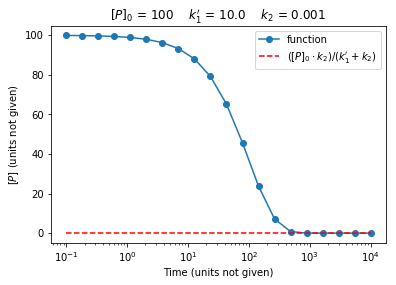

Test Passed.


True

In [6]:
import matplotlib.pyplot as plt
#this line is only needed in iPython notebooks
%matplotlib inline 

def test2(Pfunc, P0, k1prime, k2):
    '''Asymptotics test
    
    Args:
        Pfunc: a Python function to calculate P concentration. Expects 4 inputs.
        P0: initial condition to test
        k1prime: rate constant to test
        k2: rate constrant to test
        
    Returns:
        Boolean (true or false) indicated if our function passed or failed the test
    
    Side Effect:
        Creates a plot. Prints if test passed or failed.
    '''

    # Generate 20 points from 10^-2 to 10^4
    t = np.logspace(-1,4,20)
    P = P_conc(t, P0, k1prime, k2)
    
    P_infty = P0*k2/(k1prime + k2)
    # plot calculated value
    plt.semilogx(t,P,'o-',label="function")
    
    # plot calculated asymptotic value
    plt.semilogx(t,P_infty*np.ones(len(t)),color='r',linestyle="--",label="$([P]_0 \cdot k_{2}) / (k_{1}'+k_{2})$")
    
    # label plot
    plt.xlabel('Time (units not given)')
    plt.ylabel('$[P]$ (units not given)')
    plt.title("$[P]_0$ = " + str(P0) + "    $k_1'$ = " + str(k1prime) + "    $k_2$ = " + str(k2))
    plt.legend()
    plt.show()
    
    # check if solution converges to asymptotic value
    if math.fabs(P[-1] - P_infty) < 1E-6:
        # Note: P[-1] accesses the last value in array P
        print("Test Passed.")
        return True
    else:
        print("Test Failed. Either debug code or increase time in test.")
        return False
    
test2(P_conc, 100, 10.0, 0.001)

### 1.10.1.4 Test 3: Check a Few Inputs

We can calculate with pencil, paper and a calculator values for $[P]$ for a few sets of inputs. We can then test if our Python code is close.

For simplicity, let's consider $t=1$, $P[0] = 1$, $k_1' = 1$, $k_2 = 1$.

$$-(k_{1}'+k_{2})t = - (1 + 1) \cdot (1) = -2$$

$$e^{-2} \approx 0.13534$$

$$\frac{k_{2}}{k_{1}'+k_{2}} = \frac{1}{1 + 1} = 0.5$$

$$\frac{k_{1}}{k_{1}'+k_{2}} = \frac{1}{1 + 1} = 0.5$$

Combine it all together:

$$
[P] = [P]_{0}\Big(\frac{k_{2}}{k_{1}'+k_{2}}+\frac{k_{1}'}{k_{1}'+k_{2}}e^{-(k_{1}'+k_{2})t}\Big) = (1) \left(0.5 + 0.5 \cdot e^{-2} \right) \approx 0.56766
$$


*Hint:* Remember, do not use an exact equality with floating point numbers. Instead, we check if the answers agree within a tolerance. See Class 1 for more details.

In [7]:
# Define test 3 as a function
def test3(Pfunc):
    '''Test function for known solution with t=1, [P0] = 1, k1prime = 1, k2 = 1
    
    Arg:
        Pfunc: a Python function to calculate P concentration. Expects 4 inputs.
        
    Returns:
        Boolean (true or false) indicated if our function passed or failed the test
    
    Side Effect:
        Prints test parameters and message to screen
    '''
    
    # Notice how using the keyword arguments makes the code very clear
    P = Pfunc(t=1.0,P0=1.0,k1prime=1.0,k2=1.0)
    
    if math.fabs(P - 0.56766764161) < 1E-6:
        print("Passed Test 3.")
        return True
    else:
        print("Failed Test 3. Recreate your calculations and debug your code.")
        return False

# Run test   
test3(P_conc)

Failed Test 3. Recreate your calculations and debug your code.


False

# 1.10 Debugging

Now that we've identified that our code has a bug, the process of finding that error is called debugging. Given that we ran three tests, and two of them passed we can use how the tests are different to identify where the bug might be.

We'll repeat the formula and function again:

$$
[P] = [P]_{0}\Big(\frac{k_{2}}{k_{1}'+k_{2}}+\frac{k_{1}'}{k_{1}'+k_{2}}e^{-(k_{1}'+k_{2})t}\Big) ~.
$$

In [8]:
import numpy as np
def P_conc(t, P0, k1prime, k2, LOUD=False):
    """ Computes the concentration of phenolphthalein as a function of time
    
    Args:
        t: time, either a scalar (float) or vector (numpy array)
        P0: initial concentration of phenolphthalein
        k1prime: forward reaction rate constant
        k2: reverse reaction rate constant
        
    Returns:
        concentration, either a scalar (float) or vector (numpy array) depening in arg. t
    """
    # compute first fraction in formula
    frac1 = k2/(k1prime + k2)
    
    # compute section fraction in formula
    frac2 = k1prime/(k1prime + k2)
    
    # compute term that goes into exponent
    pre_expon = -(k1prime * k2)*t
    
    # evaluate exponent
    expon = np.exp(pre_expon)
    
    # combine together
    P = P0*(frac1 + frac2*expon)
    
    if LOUD:
        print("frac1 = ",frac1)
        print("frac2 = ",frac2)
        print("pre_expon = ",pre_expon)
        print("expon = ",expon)
        print("P = ",P)
    
    # return final value
    return P

### 1.10.1 Debugging is a Mindset

To properly identify the bug you need to think about
<ol>
<li> How is the code failing?
<li> What is the code doing correctly?
<li> What pieces of the code are most likely to have an error?
</ol>

Moreover, your best tool for debugging is the <tt>print</tt> function.  When in doubt have the code print out what happens after every line and check that with your intuition/expectation.

<b>When in doubt, print it (all) out!</b>

Notice that we used the ``LOUD`` keyword to help us quick toggle print statements on and off. You should always use this trick in this class.

Let's use the print statements to walk through the tests.


### Test 1

**Test 1** checks that we get the initial condition at $t=0$. We expect that ``prexpon`` evaluates to 0.0 and ``expon`` evaluates to 1.0. Let's see if this is happening:

In [9]:
P_conc(t=0.0, P0=1.0, k1prime = 1.0, k2 = 1.0, LOUD = True)

frac1 =  0.5
frac2 =  0.5
pre_expon =  -0.0
expon =  1.0
P =  1.0


1.0

With ``expon`` at 1.0, **Test 1** checks that ``frac1`` and ``frac2`` sum to 1.0, which they do. Thus, it makes sense that **Test 1** passes.

### 1.10.2 Test 2

**Test 2** checks for the correct properties as $t \rightarrow \infty$. Let's look at the output with ``t`` set to a huge number.

In [10]:
P_conc(t=1E7, P0=1.0, k1prime = 1.0, k2 = 2.0, LOUD = True)

frac1 =  0.6666666666666666
frac2 =  0.3333333333333333
pre_expon =  -20000000.0
expon =  0.0
P =  0.6666666666666666


0.6666666666666666

As expected, with ``t`` set to $10^7$, ``expon`` evaluates to 0.0. This kills ``frac2``. The calculated value for ``P`` matches ``frac1``, which we expect.

### 1.10.3 Test 3

Now let's compare the intermediate values we calculated by hand in **Test 3** to those reported below:

In [11]:
P_conc(t=1.0, P0=1.0, k1prime = 1.0, k2 = 1.0, LOUD = True)

frac1 =  0.5
frac2 =  0.5
pre_expon =  -1.0
expon =  0.36787944117144233
P =  0.6839397205857212


0.6839397205857212

<div style="background-color: rgba(255,0,0,0.05) ; padding: 10px; border: 1px solid darkred;"> 
<b>Tutorial Activity</b>: Examine the output from Tests 1, 2 and 3 above. Find and correct the bug in our code. Then rerun the tests.
</div>


TEST 1...
Testing initial condition with following specifications:
P0 =  1.0   k1prime =  1.0   k2 =  1.0
Calculate value of P =  1.0
Test passed.

Testing initial condition with following specifications:
P0 =  5.0   k1prime =  1.0   k2 =  0.001
Calculate value of P =  5.000000000000001
Test passed.


TEST 2...


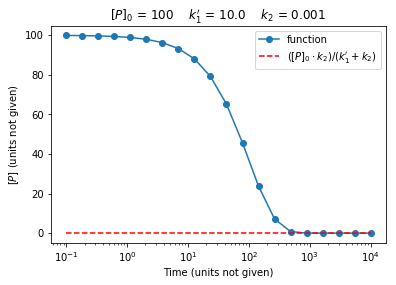

Test Passed.

TEST 3...
Passed Test 3.


True

In [12]:
import numpy as np

# Find the bug and fix this function
def P_conc_fixed(t, P0, k1prime, k2, LOUD=False):
    """ Computes the concentration of phenolphthalein as a function of time
    
    Args:
        t: time, either a scalar (float) or vector (numpy array)
        P0: initial concentration of phenolphthalein
        k1prime: forward reaction rate constant
        k2: reverse reaction rate constant
        
    Returns:
        concentration, either a scalar (float) or vector (numpy array) depening in arg. t
    """
    # compute first fraction in formula
    frac1 = k2/(k1prime + k2)
    
    # compute section fraction in formula
    frac2 = k1prime/(k1prime + k2)
    
    # compute term that goes into exponent
    pre_expon = -(k1prime + k2)*t
    
    # evaluate exponent
    expon = np.exp(pre_expon)
    
    # combine together
    P = P0*(frac1 + frac2*expon)
    
    if LOUD:
        print("frac1 = ",frac1)
        print("frac2 = ",frac2)
        print("pre_expon = ",pre_expon)
        print("expon = ",expon)
        print("P = ",P)
    
    # return final value
    return P

# Rerun the tests
print("\nTEST 1...")
test1(P_conc_fixed,1.0,1.0,1.0)
test1(P_conc_fixed, 5.0, 1.0, 0.001)

print("\nTEST 2...")
test2(P_conc_fixed, 100, 10.0, 0.001)

print("\nTEST 3...")
test3(P_conc_fixed)

Testing initial condition with following specifications:
P0 =  1.0   k1prime =  1.0   k2 =  1.0
Calculate value of P =  1.0
Test passed.

Testing initial condition with following specifications:
P0 =  5.0   k1prime =  1.0   k2 =  0.001
Calculate value of P =  5.000000000000001
Test passed.



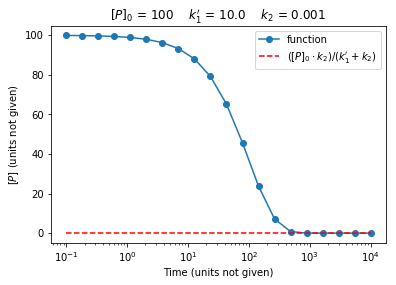

Test Passed.
Passed Test 3.


<div style="background-color: rgba(255,0,0,0.05) ; padding: 10px; border: 1px solid darkred;"> 
<b>Tutorial Activity</b>: When first typing this model, I mistaking specified <tt>pre_expon = -(k1prime) + k2*t</tt>. Without running any Python code, which tests would fail with this bug? (This is a good exam practice question.)
</div>

Write your answer here:

# 1.10 Assertions

In life it pays to be assertive.  The same is true in programming.  Let's try an example.

In [14]:
test_P = P_conc(t=10.0, P0=-10, k1prime=1, k2=1)
print("With negative P0, P(t=10) =", test_P)

With negative P0, P(t=10) = -5.000226999648812


The code worked, but the answer is non-sensical.  We'd like to tell the user that ``P_calc`` was called with an improper value. We could just change the help text to indicate that each input needs to be greater than zero. 

In [15]:
import numpy as np

def P_conc_docs(t, P0, k1prime, k2, LOUD=False):
    """ Computes the concentration of phenolphthalein as a function of time
    
    Args:
        t: time, either a scalar (float) or vector (numpy array)
        P0: initial concentration of phenolphthalein, MUST BE POSITIVE
        k1prime: forward reaction rate constant, MUST BE POSITIVE
        k2: reverse reaction rate constant, MUST BE POSITIVE
        
    Returns:
        concentration, either a scalar (float) or vector (numpy array) depening in arg. t
    """
    # compute first fraction in formula
    frac1 = k2/(k1prime + k2)
    
    # compute section fraction in formula
    frac2 = k1prime/(k1prime + k2)
    
    # compute term that goes into exponent. bug has been fixed
    pre_expon = -(k1prime + k2)*t
    
    # evaluate exponent
    expon = np.exp(pre_expon)
    
    # combine together
    P = P0*(frac1 + frac2*expon)
    
    if LOUD:
        print("frac1 = ",frac1)
        print("frac2 = ",frac2)
        print("pre_expon = ",pre_expon)
        print("expon = ",expon)
        print("P = ",P)
    
    # return final value
    return P

In [16]:
help(P_conc_docs)

#the result is the same
test_P = P_conc_docs(t=10.0, P0=-10, k1prime=1, k2=1)
print("With negative P0, P(t=10) =", test_P)

Help on function P_conc_docs in module __main__:

P_conc_docs(t, P0, k1prime, k2, LOUD=False)
    Computes the concentration of phenolphthalein as a function of time
    
    Args:
        t: time, either a scalar (float) or vector (numpy array)
        P0: initial concentration of phenolphthalein, MUST BE POSITIVE
        k1prime: forward reaction rate constant, MUST BE POSITIVE
        k2: reverse reaction rate constant, MUST BE POSITIVE
        
    Returns:
        concentration, either a scalar (float) or vector (numpy array) depening in arg. t

With negative P0, P(t=10) = -5.000000010305769


Well the result is the same: if the user doesn't respect the instruction for the function inputs, the function will behave strangely. It could be even worse:

In [17]:
test_P = P_conc_docs(t=10.0, P0=-10, k1prime=0.0, k2=0.0)
print("With negative k1prime and negative k2, P(t=10) =", test_P)

ZeroDivisionError: float division by zero

This is where the assert statement comes in.  It can assure that the arguments to the function are what they should be.

In [18]:
import numpy as np
def P_conc_assert(t, P0, k1prime, k2, LOUD=False):
    """ Computes the concentration of phenolphthalein as a function of time
    
    Args:
        t: time, either a scalar (float) or vector (numpy array)
        P0: initial concentration of phenolphthalein, MUST BE POSITIVE
        k1prime: forward reaction rate constant, MUST BE POSITIVE
        k2: reverse reaction rate constant, MUST BE POSITIVE
        
    Returns:
        concentration, either a scalar (float) or vector (numpy array) depening in arg. t
    """
    
    assert (P0 >0)
    assert (k1prime > 0) 
    assert (k2 >0)
    assert (k1prime + k2 > 1E-10)
    
    # compute first fraction in formula
    frac1 = k2/(k1prime + k2)
    
    # compute section fraction in formula
    frac2 = k1prime/(k1prime + k2)
    
    # compute term that goes into exponent. bug has been fixed
    pre_expon = -(k1prime + k2)*t
    
    # evaluate exponent
    expon = np.exp(pre_expon)
    
    # for some problems, it makes sense to also apply assert to intermediate values
    
    # combine together
    P = P0*(frac1 + frac2*expon)
    
    if LOUD:
        print("frac1 = ",frac1)
        print("frac2 = ",frac2)
        print("pre_expon = ",pre_expon)
        print("expon = ",expon)
        print("P = ",P)
    
    # return final value
    return P

In [19]:
test_P = P_conc_assert(t=10.0, P0=1.0, k1prime=0.0, k2=0.0)
print("With negative k1prime and negative k2, P(t=10) =", test_P)

AssertionError: 

Notice that python tells us which assertion failed so we know that the function call had a bad value of ``k1prime``.  The program still fails, but it tells us exactly why. We can also use assertions to test that the code behaves the way we expect.

These types of assert statements can help you debug later on down the road.

# 1.10 Error Handling

There are times when you want to handle an error gracefully. When a program is running, if it encounters an error it can raise and exception. The exception will give some indication of what the error is. In Python, you can place some code in a special block of code called a **try block**. After the try block, the types of exception to handle are listed using except blocks. Only the exceptions that are explicitly handled are caught.

One type of exception is the ``ZeroDivisionError`` that is raised when a number is divided by zero. First, we will look at an uncaught exception:

In [20]:
z = 10.5/0

ZeroDivisionError: float division by zero

In [25]:
try:
    z = 10.5/0
except ZeroDivisionError:
    print("You cannot Divide by zero")


You cannot Divide by zero


One thing that happens when you catch a raised exception, is that **the program will continue on**. This can be a useful feature, but often times you want to catch an exception, print a useful error message, and then have the program end. This can be done by adding a ``raise`` statement to the end of the except block. The raise statement tells Python to still fail due to the exception, despite the fact that we caught it. This changes the previous example by one line, but changes the output and forces the program to quit:

In [24]:
try:
    z = 10.5/0
except ZeroDivisionError:
    print("You cannot divide by 0, exiting")
    raise # kill the program

You cannot divide by 0, exiting


ZeroDivisionError: float division by zero

Let's see this applied to our reaction kinetics example.

In [22]:
import numpy as np
def P_conc_assert2(t, P0, k1prime, k2, LOUD=False):
    """ Computes the concentration of phenolphthalein as a function of time
    
    Args:
        t: time, either a scalar (float) or vector (numpy array)
        P0: initial concentration of phenolphthalein, MUST BE POSITIVE
        k1prime: forward reaction rate constant, MUST BE POSITIVE
        k2: reverse reaction rate constant, MUST BE POSITIVE
        
    Returns:
        concentration, either a scalar (float) or vector (numpy array) depening in arg. t
    """
    try:
        assert (P0 >0)
        assert (k1prime > 0) 
        assert (k2 >0)
        assert (k1prime + k2 > 1E-10)
    except AssertionError:
        print("Input Parameters are not all positive.") 
        print("P0 =",P0) 
        print("k1prime =",k1prime)
        print("k2 =",k2)
        raise # kill the program
    except:
        print("An unexpected error occurred when",
                              "checking the function parameters")
        raise # kill the program
    
    
    # compute first fraction in formula
    frac1 = k2/(k1prime + k2)
    
    # compute section fraction in formula
    frac2 = k1prime/(k1prime + k2)
    
    # compute term that goes into exponent. bug has been fixed
    pre_expon = -(k1prime + k2)*t
    
    # evaluate exponent
    expon = np.exp(pre_expon)
    
    # for some problems, it makes sense to also apply assert to intermediate values
    
    # combine together
    P = P0*(frac1 + frac2*expon)
    
    if LOUD:
        print("frac1 = ",frac1)
        print("frac2 = ",frac2)
        print("pre_expon = ",pre_expon)
        print("expon = ",expon)
        print("P = ",P)
    
    # return final value
    return P


With this function, if it is passed a negative value, will raise an <tt>AssertionError</tt>. The code catches this error, prints out the input parameters to the user, and then exits by raising the exception.

In [23]:
test_P = P_conc_assert2(t=10.0, P0=1.0, k1prime=0.0, k2=0.0)
print("With negative k1prime and negative k2, P(t=10) =", test_P)

Input Parameters are not all positive.
P0 = 1.0
k1prime = 0.0
k2 = 0.0


AssertionError: 

Also, the function has a generic except statement that will catch any other errors in the try block. Because the try block involves comparison of numbers, if we pass a string as a parameter, there will be an error when checking if that parameter is greater than 0. This exception will be caught by the generic except statement, and the code prints out an error message, and then quits:

In [26]:
test_P = P_conc_assert2(t=10.0, P0="hello world", k1prime=0.0, k2=0.0)
print("With negative k1prime and negative k2, P(t=10) =", test_P)

An unexpected error occurred when checking the function parameters


TypeError: '>' not supported between instances of 'str' and 'int'

<!--NAVIGATION-->
< [1.9 Functions as Arguments](https://ndcbe.github.io/cbe-xx258/01.09-Functions-as-Arguments.html) | [Contents](toc.html) | [2.0 Linear Algebra](https://ndcbe.github.io/cbe-xx258/02.00-Linear-Algebra.html) ><p><a href="https://colab.research.google.com/github/ndcbe/cbe-xx258/blob/master/docs/01.10-Testing-and-Debugging.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe-xx258/01.10-Testing-and-Debugging.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>